<img src="./logo_UNSAM.jpg" align="right" width="150" />  -->

#### Análisis y procesamiento de señales

# Trabajo Práctico Final - Actualizaciones

#### Santiago Manuel Corral

En este notebook se irán subiendo las actualizaciones y el desarrollo del TP para su registro y análisis.  

#### Inicialización de librerías

In [4]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import signal

#### Funciónes definidas

In [19]:
# //// Plot los 4 canales dado un trial y sujeto //// 
def plot_emg(data_dict, subject = 1, trial = 1):
    subjectt = f'subject_{subject}'
    triall = f'trial_{trial}'
    
    # Acceder a los datos
    emg = data_dict[subjectt][triall]['emg']     # matriz Nx4
    time = data_dict[subjectt][triall]['time']   # matriz Nx4
    labels_time = data_dict[subjectt][triall]['label_times']
    labels = data_dict[subjectt][triall]['labels']
    
    # Buscar los tiempos de transición
    t1 = None
    t2 = None

    t1 = labels_time[np.where(labels == 1)[0][0]]
    t2 = labels_time[np.where(labels == 2)[0][0]]
    
    #PLOT
    plt.figure(figsize=(12, 10))
    plt.title(f"Sujeto {subject} Ejercicio {trial}")
    
    for i in range(4):
        plt.subplot(4, 1, i + 1)
        plt.plot(time[:, i], emg[:, i], label=f'Canal {i + 1}')
        plt.axvline(x=t1, linestyle='--', color='black', label='Fatiga nivel 1' if i == 0 else "")
        plt.axvline(x=t2, linestyle='--', color='red', label='Fatiga nivel 2' if i == 0 else "")
        plt.ylabel("EMG (V)")
        plt.grid(True)
        plt.legend(loc='upper right')

    plt.xlabel("Tiempo (s)")
    plt.tight_layout()
    plt.show()


# //// Plot canal ppal dado un trial para todos los sujetos ////     
def plot_emg_all_canal(data_dict, trial_num, canal):
    
    plt.figure()  # Altura grande para 13 subplots

    for i in range(1, 7):  # sujetos
        subject = f'subject_{i}'
        trial = f'trial_{trial_num}'

        plt.subplot(13, 1, i)  # 13 filas, 1 columna, subplot i
       
        emg = data_dict[subject][trial]['emg']
        time = data_dict[subject][trial]['time']
            
        plt.plot(time[:, canal], emg[:, canal], label=subject)
        plt.ylabel("EMG (V)")
        plt.grid(True)
        plt.legend(fontsize=8, loc='upper right')
    

    plt.suptitle(f"Trial {trial_num} - Canal {canal + 1}", fontsize=16, y=0.92)
    plt.xlabel("Tiempo (s)")
    plt.tight_layout()
    plt.show()

# //// Plot canal ppal dado un trial para todos los sujetos ////     
def plot_emg_all(data_dict, trial_num):
    
    plt.figure(figsize=(15, 13))  # Altura grande para 13 subplots

    for i in range(1, 7):  # sujetos
        subject = f'subject_{i}'
        trial = f'trial_{trial_num}'
        

        plt.subplot(7, 1, i)  # 13 filas, 1 columna, subplot i
       
        #Carga de datos
        emg = data_dict[subject][trial]['emg']
        time = data_dict[subject][trial]['time']
        labels_time = data_dict[subject][trial]['label_times']
        labels = data_dict[subject][trial]['labels']
        
        # Buscar los tiempos de transición
        t1 = None
        t2 = None

        t1 = labels_time[np.where(labels == 1)[0][0]]
        t2 = labels_time[np.where(labels == 2)[0][0]]
        
        #Plot
        plt.plot(time[:], emg[:], label=subject)
        plt.axvline(x=t1, linestyle='--', color='black', label='Fatiga nivel 1' if i == 1 else None)
        plt.axvline(x=t2, linestyle='--', color='red', label='Fatiga nivel 2' if i == 1 else None)
        plt.ylabel("EMG (V)")
        plt.grid(True)
        plt.legend(loc='upper right')
    

    plt.suptitle(f"Trial {trial_num}", fontsize=16, y=0.92)
    plt.xlabel("Tiempo (s)")
    plt.show()    

# //// Mapa con el canal del musculo ppal. para cada trial //// 
def get_agonista(trial):
    mapping = {
        1: 1,  2: 0,     # Deltoides anterior
        3: 3,  4: 2,     # Deltoides posterior
        5: 0,  6: 1,     # Biceps Brachii
        7: 2,  8: 3,     # Deltoide Medio
        9: 1, 10: 0,     # Deltoide anterior (complejo)
        11:3, 12:2       # Deltoide posterior (complejo)
    }
    return mapping.get(trial, None)


#### Carga de archivos

In [6]:
# //// Carga de la matriz COMPLETA ////
# Rutas
dir_emg = r"C:\Users\santi\Desktop\Facu\APS\TP Final\EMG-Self-Perceived\sEMG_data"
dir_gt =  r"C:\Users\santi\Desktop\Facu\APS\TP Final\EMG-Self-Perceived\self_perceived_fatigue_index"

# Parámetros
subject_numbers = range(1, 7)  # Se define la ctd. de sujetos
EMG_index = [1, 3, 5, 7] #Columnas de los canales y los tiempos correspondientes del .csv
time_index = [0, 2, 4, 6]

# Diccionario
data_dict = {}

for subject_number in subject_numbers: #Recorremos los sujetos
    subject_key = f"subject_{subject_number}"
    data_dict[subject_key] = {} #Inicializa el diccionario en subject_X

    emg_folder = os.path.join(dir_emg, f"subject_{subject_number}")
    gt_folder  = os.path.join(dir_gt,  f"subject_{subject_number}")

    #Ordenamos los ensayos para cada sujeto
    emg_files = sorted([f for f in os.listdir(emg_folder) if f.endswith('.csv')], key=lambda x: int(re.findall(r'\d+', x)[-1]))
    
    for emg_file in emg_files: #Por cada .csv de emg_files (c/u de los ensayos)
        trial_number = int(re.findall(r'\d+', emg_file)[-1]) #Extraemos el numero de cada trial
        trial_key = f"trial_{trial_number}" 

        # Rutas completas hacia cada uno de los trials para el subject_X
        emg_path = os.path.join(emg_folder, emg_file)
        gt_path = os.path.join(gt_folder, emg_file)

        # Leemos EMG
        dataframe_emg = pd.read_csv(emg_path) #lee valores del .csv y los convierte en un data frame (parecido a un struct)
        ## Tenemos filas --> ctd. muestras
        ## Columnas --> variables medidas (Tiempo, Valores EMG)
        
        emg_data = dataframe_emg.iloc[:, EMG_index].values #Guardamos columnas de EMG (indices definidos al ppo.)
        time_data = dataframe_emg.iloc[:, time_index].values #Guardamos columnas de tiempo 

        # Leer etiquetas de indices de fatiga
        if os.path.exists(gt_path):
            dataframe_fatigue = pd.read_csv(gt_path) #Creamos data frame con los indices de fatiga
            label_times = dataframe_fatigue.iloc[:, 0].values #Primer columna del DF --> tiempos
            label_values = dataframe_fatigue.iloc[:, 1].values #Segunda columna del DF --> indices
        else:
            label_times = np.array([]) #De no existir los valores de fatiga, array vacio
            label_values = np.array([])

        # Creamos el diccionario
        data_dict[subject_key][trial_key] = {
            'emg': emg_data,
            'time': time_data,
            'labels': label_values,
            'label_times': label_times
        }
        
# //// Carga de la matriz unicamente musculos Agonistas ////
# Rutas
dir_emg = r"C:\Users\santi\Desktop\Facu\APS\TP Final\EMG-Self-Perceived\sEMG_data"
dir_gt =  r"C:\Users\santi\Desktop\Facu\APS\TP Final\EMG-Self-Perceived\self_perceived_fatigue_index"

# Parámetros
subject_numbers = range(1, 13)  # Se define la ctd. de sujetos
EMG_index = [1, 3, 5, 7]  # Columnas de los 4 canales EMG
time_index = [0, 2, 4, 6]  # Columnas de tiempo correspondientes
sample_freq = 1259

# Diccionario de salida
data_dict2 = {}

# Recorrer sujetos
for subject_number in subject_numbers:
    subject_key = f"subject_{subject_number}"
    data_dict2[subject_key] = {}

    emg_folder = os.path.join(dir_emg, f"subject_{subject_number}")
    gt_folder  = os.path.join(dir_gt,  f"subject_{subject_number}")

    emg_files = sorted(
        [f for f in os.listdir(emg_folder) if f.endswith('.csv')],
        key=lambda x: int(re.findall(r'\d+', x)[-1])
    )

    for emg_file in emg_files:
        trial_number = int(re.findall(r'\d+', emg_file)[-1])
        trial_key = f"trial_{trial_number}"
        emg_path = os.path.join(emg_folder, emg_file)
        gt_path = os.path.join(gt_folder, emg_file)

        # Leer .csv
        df_emg = pd.read_csv(emg_path)

        # Obtener índice del canal principal (agonista)
        index = get_agonista(trial_number)
        if index is None:
            continue  # saltar si no se encuentra un canal válido

        # Me quedo unicamente con las columnas del record ppal. 
        emg_column = EMG_index[index]
        time_column = time_index[index]

        emg_data = df_emg.iloc[:, emg_column].values
        time_data = df_emg.iloc[:, time_column].values

        # Leer etiquetas si existen
        if os.path.exists(gt_path):
            df_fatigue = pd.read_csv(gt_path)
            label_times = df_fatigue.iloc[:, 0].values
            label_values = df_fatigue.iloc[:, 1].values
        else:
            label_times = np.array([])
            label_values = np.array([])

        # Guardar en el diccionario
        data_dict2[subject_key][trial_key] = {
            'emg': emg_data,
            'time': time_data,
            'labels': label_values,
            'label_times': label_times
        }

Generamos entonces un diccionario ("data_dict") con los datos extraídos del data set, siguiendo la disposición original de los archivos, con la siguiente forma:
<center><img src="./Estructura_diccionario.png" align="center" width="550" />
</center>

Luego, dado que la matriz completa me resulto inmanejable computacionalmente, y en principio limitaré el análisis a los músculos agonistas de cada actividad, genero una nueva matriz en la que me quedo solo con las mediciones de los canales correspondientes para cada señal. Por lo que tengo únicamente una columna de medición EMG por cada actividad ("data_dict2"). 

#### Procesamiento

Teniendo en cuenta que la señal de entrada únicamente fue procesada con un filtro anti-alias y amplificada, siendo su frecuencia de muestreo de 1259Hz. Aplicaremos únicamente un filtro pasa banda butterworth de 4 orden, debido a su máxima planicidad en la banda de paso y su eficiencia computacional con frecuencias de corte de 20 y 450 dado que este es el rango en el que encontramos las frecuencias de una típica señal de EMG. Luego aplicamos un filtrado bidireccional para anular el retardo de fase no lineal. 

Dado que en principio queremos analizar valores relativos como variaciónes de amplitud y luego frecuencia media, no tenemos interés en los valores reales de amplitud de cada canal, por lo que por comodidad podemos normalizar las señales por su máximo, obteniendo máxima amplitud en 1 para todos los canales. 

- __Filtrado__

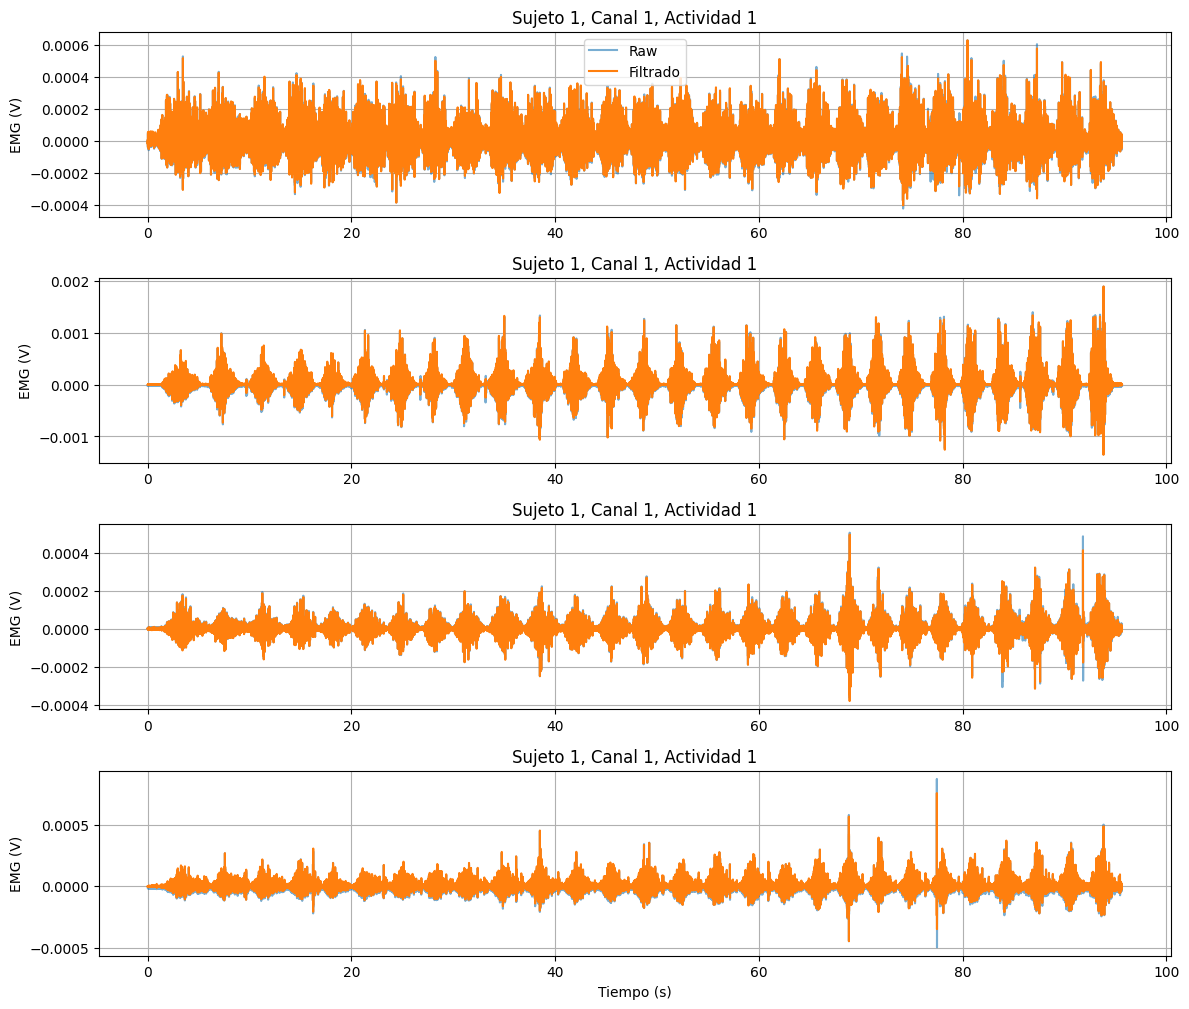

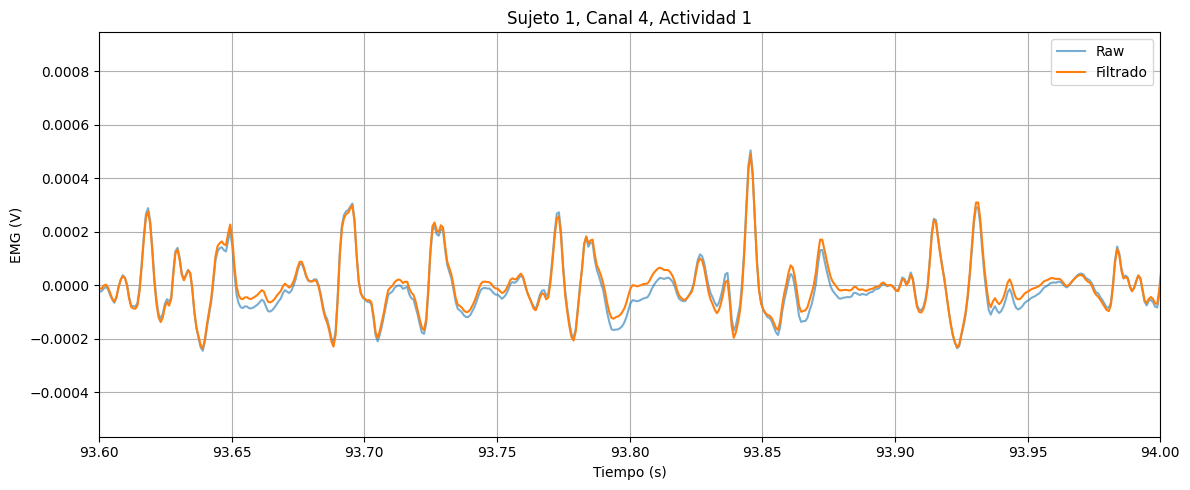

In [7]:
fs = 1259

# //// Filtrado ////
fc1, fc2 = 20, 450
b, a = signal.butter(4, [fc1, fc2], btype='bandpass', fs=fs)

# Copio el sujeto 1 para comparar
import copy
subject1_raw = {'subject_1': copy.deepcopy(data_dict['subject_1'])}
#plot_emg(subject1_raw,1,1)

#Dataset 1
for subject_key in data_dict:  # Recorremos los sujetos
    for trial_key in data_dict[subject_key]:  # Recorremos los ensayos
        emg_raw = data_dict[subject_key][trial_key]['emg']  # Matriz Nx4

        # Filtrado bidireccional canal por canal
        emg_filtered = np.zeros_like(emg_raw)
        for i in range(4):
            emg_filtered[:, i] = signal.filtfilt(b, a, emg_raw[:, i])

        # Reemplazo en el diccionario original
        data_dict[subject_key][trial_key]['emg'] = emg_filtered

# Dataset 2
for subject_key in data_dict2: #Recorremos los sujetos
    for trial_key in data_dict2[subject_key]:
        emg_raw = data_dict2[subject_key][trial_key]['emg']
        
        # Filtrado bidireccional para anular los problemas de fase
        emg_filtered = signal.filtfilt(b, a, emg_raw)
        
        # Reemplazo en el diccionario
        data_dict2[subject_key][trial_key]['emg'] = emg_filtered
subject = 'subject_1'
trial = 'trial_1'

# //// Ploteo comparativo ////
# Extraer señales
emg_raw = subject1_raw[subject][trial]['emg']       # Sin filtrar
emg_filt = data_dict[subject][trial]['emg']         # Filtrado
time = data_dict[subject][trial]['time']            # Tiempo (es el mismo para ambos)

# Gráfico comparativo por canal
plt.figure(figsize=(12, 10))
for i in range(4):
    plt.subplot(4, 1, i + 1)
    plt.plot(time[:, i], emg_raw[:, i], label='Raw', alpha=0.6)
    plt.plot(time[:, i], emg_filt[:, i], label='Filtrado')
    plt.title("Sujeto 1, Canal 1, Actividad 1")
    plt.ylabel("EMG (V)")
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.xlabel("Tiempo (s)")
plt.show()

i = 3  # Canal 3 
# Gráfico comparativo para canal 3
plt.figure(figsize=(12, 5))
plt.plot(time[:, i], emg_raw[:, i], label='Raw', alpha=0.6)
plt.plot(time[:, i], emg_filt[:, i], label='Filtrado')
plt.title("Sujeto 1, Canal 4, Actividad 1")  # Título visible como Canal 4
plt.ylabel("EMG (V)")
plt.xlabel("Tiempo (s)")
plt.xlim([93.6, 94])  # Zoom en tiempo (ajustá si querés otro rango)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

- __Normalización__

Para normalizar la señal investigue que las señales EMG se suelen normalizar respecto al valor máximo de contracción (MVC), donde se le pide al sujeto que contraiga el musculo al máximo durante un tiempo corto de tiempo, luego se normaliza por el valor máximo de esa MVC. Dado que no tenemos una medición de valores máximos de contracción, normalizaremos por el valor pico de cada canal, obteniendo una amplitud máxima de uno. Dado que buscamos medir valores relativos como variaciones en la amplitud según la fatiga muscular y variaciones en la frecuencia media, en principio no nos interesan los valores reales adquiridos del EMG. 

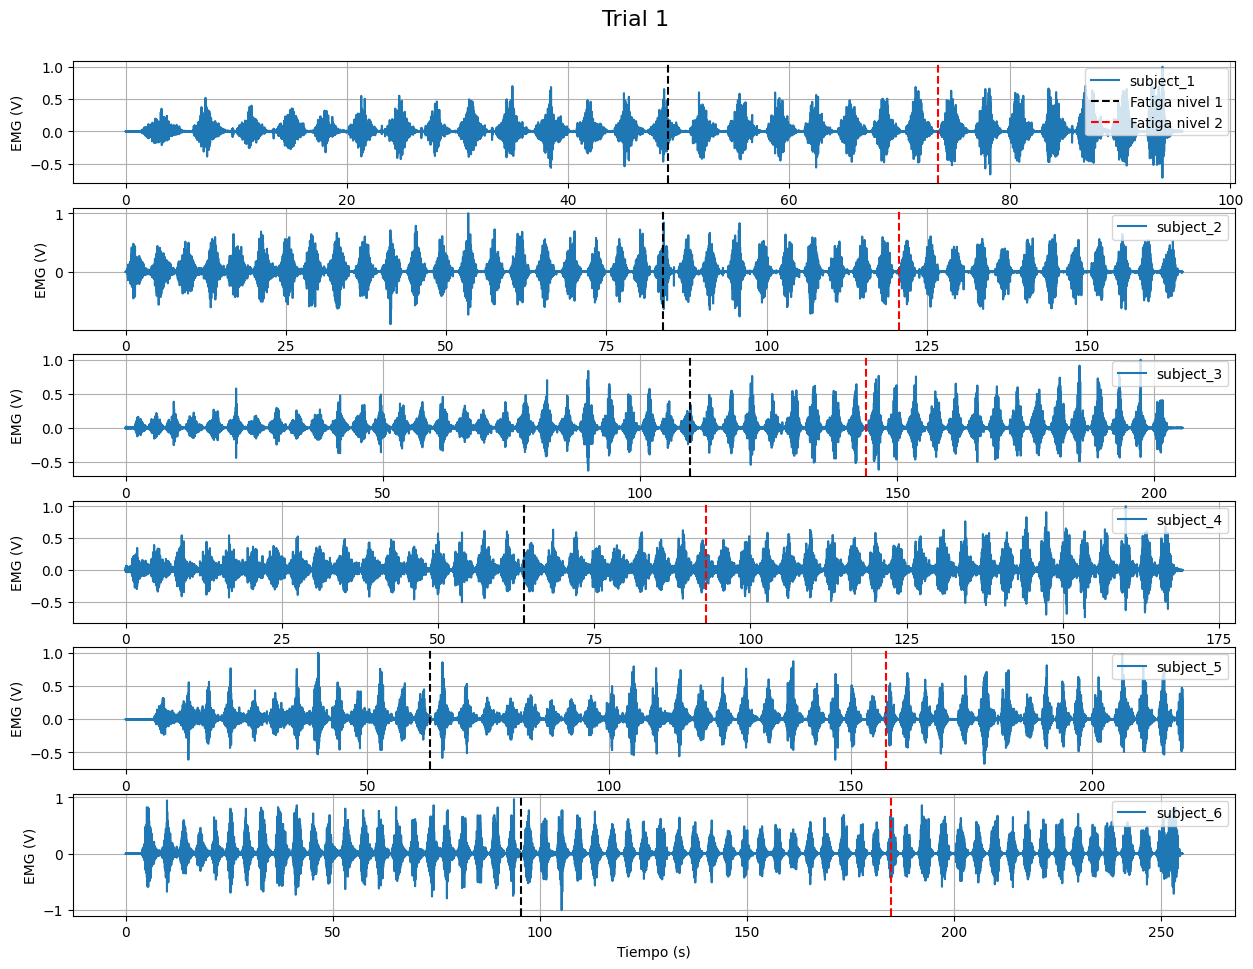

In [20]:
# //// Normalización ////

#Dataset 1
for subject_key in data_dict:
    for trial_key in data_dict[subject_key]:
        emg = data_dict[subject_key][trial_key]['emg']  # Señal ya filtrada, matriz Nx4
        
        max_vals = np.max(np.abs(emg), axis=0)

        emg_normalized = emg / max_vals  # Escalado por canal
        data_dict[subject_key][trial_key]['emg'] = emg_normalized
            
#Dataset 2
for subject_key in data_dict2:
    for trial_key in data_dict2[subject_key]:
        emg = data_dict2[subject_key][trial_key]['emg']  # Señal ya filtrada, matriz Nx4
        
        max_vals = np.max(np.abs(emg), axis=0)

        emg_normalized = emg / max_vals  # Escalado por canal
        data_dict2[subject_key][trial_key]['emg'] = emg_normalized

import matplotlib.pyplot as plt

plot_emg_all(data_dict2, 1)